In [25]:
import numpy as np

#loading training texts
texts = np.loadtxt('/content/text.txt', dtype="str", delimiter="\0")
print(texts)

['The future king is the prince' 'Daughter is the princess'
 'Son is the prince' 'Only a man can be a king'
 'Only a woman can be a queen' 'The princess will be a queen'
 'Queen and king rule the realm' 'The prince is a strong man'
 'The princess is a beautiful woman'
 'The royal family is the king and queen and their children'
 'Prince is only a boy now' 'A boy will be a man']


In [26]:
import re

def clean_text(
    string: str, 
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    # stop words are common words that provide no info
    stop_words=['the', 'a', 'and', 'is', 'be', 'will']) -> str:

    #if using websites as data
    #Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)
    #Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    string = string.lower()
    #Removing the punctuations
    for x in string: 
        if x in punctuations: 
            string = string.replace(x, "") 
    #Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    #Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string        

In [27]:
#Defining the window for context
window = 4

#Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in texts:

    #Cleaning the text
    text = clean_text(text).split()
    
    #Appending to the all text list
    all_text += text 

    #Creating a context dictionary
    for i, word in enumerate(text): # gives index along with array value
        for w in range(window):
            #Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            #Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])


In [28]:
def create_unique_word_dict(text:list) -> dict:
    #creates a dictionary where the keys are unique words and key values are indices
    words = list(set(text))
    words.sort()
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict 

In [29]:
from scipy import sparse
import numpy as np

#Defining the number of features (unique words)
unique_word_dict = create_unique_word_dict(all_text)
n_words = len(unique_word_dict)

#Getting all the unique words 
words = list(unique_word_dict.keys())

#Creating the X and Y matrices using one hot encoding (conversion of categorical data)
X = []
Y = []

for i, word_list in enumerate(word_lists):
    #Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    #Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    #One hot encoding the main word
    X_row[main_word_index] = 1

    #One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    #Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

#Converting the matrices into an array
X = np.asarray(X)
Y = np.asarray(Y)

In [30]:
#Deep learning: 
from tensorflow.keras import Input
from keras.models import Model
from keras.layers import Dense

#Defining the size of the embedding, dimensions of your vectors
embed_size = 2

#Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

#Optimizing the network weights
model.fit(x=X, y=Y, batch_size=256, epochs=1000)

#Obtaining the weights from the neural network. 
#These are the so called word embeddings

#The input layer 
weights = model.get_weights()[0]

#creating a dictionary to store the embeddings in. The key is a unique word and 
#the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({word: weights[unique_word_dict.get(word)]})

Epoch 1/1000
1/1 [==============================] - 1s 834ms/step - loss: 3.0546
Epoch 2/1000
1/1 [==============================] - 0s 10ms/step - loss: 3.0537
Epoch 3/1000
1/1 [==============================] - 0s 13ms/step - loss: 3.0527
Epoch 4/1000
1/1 [==============================] - 0s 12ms/step - loss: 3.0517
Epoch 5/1000
1/1 [==============================] - 0s 10ms/step - loss: 3.0508
Epoch 6/1000
1/1 [==============================] - 0s 10ms/step - loss: 3.0498
Epoch 7/1000
1/1 [==============================] - 0s 10ms/step - loss: 3.0489
Epoch 8/1000
1/1 [==============================] - 0s 12ms/step - loss: 3.0479
Epoch 9/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.0470
Epoch 10/1000
1/1 [==============================] - 0s 11ms/step - loss: 3.0460
Epoch 11/1000
1/1 [==============================] - 0s 12ms/step - loss: 3.0451
Epoch 12/1000
1/1 [==============================] - 0s 10ms/step - loss: 3.0442
Epoch 13/1000
1/1 [==================

Vectors of each word from training set
beautiful :  [0.94323605 0.903229  ]
boy :  [-0.98568344 -1.0075649 ]
can :  [ 0.20103282 -0.94992054]
children :  [1.193002   0.88879913]
daughter :  [0.8662603  0.95079434]
family :  [1.2834097  0.57265997]
future :  [-0.05406678 -0.83198595]
king :  [-0.09371401  0.487923  ]
man :  [-0.36512992 -1.5168898 ]
now :  [-0.612544  -1.4558845]
only :  [-0.39297453 -0.597739  ]
prince :  [-0.913773  -1.2073869]
princess :  [-0.77742416  1.2569258 ]
queen :  [0.9860124  0.30464044]
realm :  [ 0.9974013 -0.5267916]
royal :  [0.80367976 0.8393018 ]
rule :  [ 0.72515357 -0.5491341 ]
son :  [-0.6673047  -0.91948915]
strong :  [-1.2960429 -0.7825892]
their :  [0.7850319  0.59807754]
woman :  [0.28044805 0.42156637]
Popular example: king-man+woman should equal queen
king-man+woman:  [0.5518639 2.4263792]
queen:  [0.9860124  0.30464044]
cosine simularity:  0.49973887


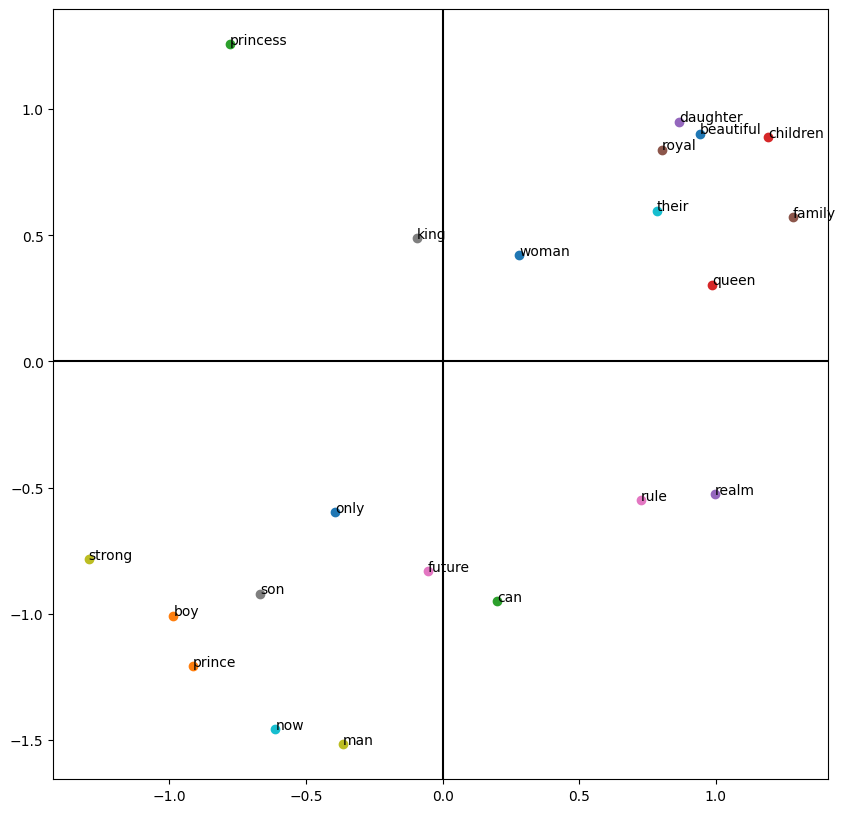

In [31]:
#displaying the vectors
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
print("Vectors of each word from training set")
for word in list(unique_word_dict.keys()):
  coord = embedding_dict.get(word)
  print(word, ": ", coord)
  plt.scatter(coord[0], coord[1])
  plt.annotate(word, (coord[0], coord[1]))

print("Popular example: king-man+woman should equal queen")
kmw = embedding_dict.get('king')-embedding_dict.get('man')+embedding_dict.get('woman')
q = embedding_dict.get('queen')
print("king-man+woman: ", kmw)
print("queen: ", q)
print('cosine simularity: ', np.dot(kmw, q)/(np.linalg.norm(q)*np.linalg.norm(kmw)))

In [33]:
#input your own test words for the model to vectorize
test_words = ['fire', 'ocean', 'wave'] 
unique_word_dict = create_unique_word_dict(test_words)
embedding_dict = {}
for word in test_words: 
    embedding_dict.update({word: weights[unique_word_dict.get(word)]})

Vectors of each word from test set
fire :  [0.94323605 0.903229  ]
ocean :  [-0.98568344 -1.0075649 ]
wave :  [ 0.20103282 -0.94992054]


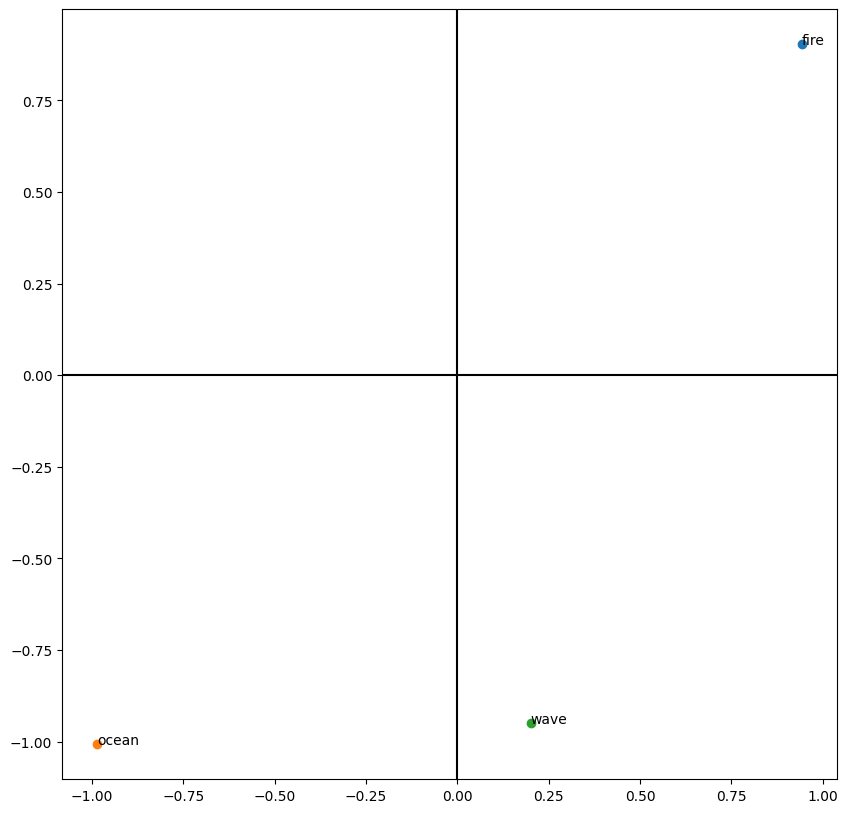

In [34]:
#plotting your test words with the model trained here
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
print("Vectors of each word from test set")
for word in list(unique_word_dict.keys()):
  coord = embedding_dict.get(word)
  print(word, ": ", coord)
  plt.scatter(coord[0], coord[1])
  plt.annotate(word, (coord[0], coord[1]))

In [11]:
#importing a better pretrained model (beware: it is 1.7 GB)
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [23]:
pairs = [
    ('car', 'minivan'),   #enter the pairs of words that you want to compare
    ('car', 'bicycle'),   
    ('car', 'airplane'), 
    ('car', 'cereal'),   
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

kmw = wv['king']-wv['man']+wv['woman']
q = wv['queen']
# print('king-man+woman: ', kmw)
# print('queen: ', q)
print('cosine simularity: ', np.dot(kmw, q)/(np.linalg.norm(q)*np.linalg.norm(kmw)))

'car'	'minivan'	0.69
'car'	'bicycle'	0.54
'car'	'airplane'	0.42
'car'	'cereal'	0.14
'car'	'communism'	0.06
cosine simularity:  0.73005176
